In [70]:
import pandas as pd
import numpy as np
from numpy import column_stack
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
#from scipy.stats import uniform
#from scipy.stats import randint
from sklearn.metrics import f1_score
from scipy import stats
from time import time
import matplotlib.pyplot as plt
from xgboost import plot_importance
import re
from scipy import sparse
from datetime import datetime
import pickle
import seaborn as sns

In [2]:
#tune per how many available per your system... 16 is max on this EC2 instance, while -1 is technically
#supposed to choose the max amount of cores it does not max work always.. see documentation link
n_threads = 36
model_scores = []
#track time for script to run


In [3]:
#set random_seed for reproduction purposes..
random_seed = 10

In [4]:
df_bayview = pd.read_csv('/home/ubuntu/CSVs/BAYVIEW_data.csv')

In [5]:
print(df_bayview.shape)

(219461, 13)


In [6]:
for col in df_bayview.columns:
    print(col)

address
category
date
dayofweek
descript
incidntnum
location
pddistrict
pdid
resolution
time
x
y


In [7]:
print(df_bayview.resolution.unique())
print(df_bayview.resolution.nunique())

['ARREST, BOOKED' 'NONE' 'UNFOUNDED' 'ARREST, CITED'
 'DISTRICT ATTORNEY REFUSES TO PROSECUTE' 'LOCATED' 'JUVENILE BOOKED'
 'JUVENILE CITED' 'PROSECUTED FOR LESSER OFFENSE' 'PSYCHOPATHIC CASE'
 'NOT PROSECUTED' 'PROSECUTED BY OUTSIDE AGENCY'
 'COMPLAINANT REFUSES TO PROSECUTE' 'JUVENILE DIVERTED'
 'EXCEPTIONAL CLEARANCE' 'JUVENILE ADMONISHED'
 'CLEARED-CONTACT JUVENILE FOR MORE INFO']
17


In [8]:
#Only going to drop columns with 100% no relevance or correlation and then use
#OHE, label encoding on non numeric types...  Will test with only labelencoder as well(all ordinal)
#Drop Columns pdid, pddistrict(Already split by district), incidentnum, pdid, location, description(Can't use b/c its cheating)
df_bayview = df_bayview.drop(columns=['pddistrict', 'incidntnum', 'pdid', 'location', 'descript'])

In [9]:
print(df_bayview.shape)

(219461, 8)


In [10]:
for col in df_bayview.columns:
    print(col)

address
category
date
dayofweek
resolution
time
x
y


In [11]:
df_y = df_bayview['category']
#put category column into seperate target DF

In [12]:
#drop category column from feature dataframe.
df_x = df_bayview.drop(columns=['category'])
for col in df_x.columns:
    print(col)

address
date
dayofweek
resolution
time
x
y


In [13]:
#39 UNIQUE CATEGORIES BASED ON THIS NUMBER
print(df_y.nunique())

39


In [14]:
#use labelencoder to convert to numeric/integer values
labelencoder = LabelEncoder()
labelencoder = labelencoder.fit(df_y)
#list(labelencoder.classes_)


In [15]:
labelencoded_y = labelencoder.transform(df_y)

In [16]:
labelencoded_y.shape

(219461,)

In [17]:
#integer versions of targets
#print(labelencoded_y)

In [18]:
#this lists all the integer versions of categories as strings again..
#for my own use to test labelencoder
#list(labelencoder.inverse_transform(labelencoded_y))

In [19]:
#drop category column from feature dataframe.
###test up to here should be address, date, dow, resolution, time, x and y as columns

In [20]:
#address, dayofweek, resolution need to be onehotencoded..
#date needs to be seperated 
#time needs to be 
#might need to chop off loc as it is very specific
#first step is to convert date to 3 seperate columns

In [21]:
#convert date to seperate values for day, month, hour
def convert_date_to_day(dt):

   result = re.findall(r'\d{4}-(\d{2})-(\d{2})T00:00:00.000',dt)

   return result[0][1]

   

def convert_date_to_month(dt):

   result = re.findall(r'\d{4}-(\d{2})-(\d{2})T00:00:00.000',dt)

   return result[0][0]


def convert_date_to_year(dt):
    
    result = re.findall(r'(\d{4})-(\d{2})-(\d{2})T00:00:00.000',dt)

    return result[0][0]

def convert_time_to_hour(tm):

   result = re.findall(r'(\d{2}):\d{2}',tm)

   return result[0]


In [22]:
df_x['day'] = df_x.date.apply(lambda x: convert_date_to_day(x))
df_x['month'] = df_x.date.apply(lambda x: convert_date_to_month(x))
df_x['year'] = df_x.date.apply(lambda x: convert_date_to_year(x))
df_x['hour'] = df_x.time.apply(lambda x: convert_time_to_hour(x))

In [23]:
# print(df_x.year.unique())
# print(df_x.month.unique())
# print(df_x.day.unique())
# print(df_x.hour.unique())

In [24]:
#drop year column from feature dataframe.
df_x = df_x.drop(columns=['date', 'time'])
for col in df_x.columns:
    print(col)

address
dayofweek
resolution
x
y
day
month
year
hour


In [25]:
#check which input features are string types/non-integers so I know which ones I need
#to one hot encode for use in XGB
print("address", type(df_x.address.iloc[1]))
print("dayofweek", type(df_x.dayofweek.iloc[1]))
print("resolution", type(df_x.resolution.iloc[1]))
print("day", type(df_x.day.iloc[1]))
print("month", type(df_x.month.iloc[1]))
print("year", type(df_x.year.iloc[1]))
print("hour", type(df_x.hour.iloc[1]))
print("x", type(df_x.x.iloc[1]))
print("y", type(df_x.y.iloc[1]))

('address', <type 'str'>)
('dayofweek', <type 'str'>)
('resolution', <type 'str'>)
('day', <type 'str'>)
('month', <type 'str'>)
('year', <type 'str'>)
('hour', <type 'str'>)
('x', <type 'numpy.float64'>)
('y', <type 'numpy.float64'>)


In [26]:
#need to OHE address, dayofweek, resolution
#convert time, day, month, year to ints? or OHE?

In [27]:
#df_x will be with used for all labelencoded/none OHE'd
#df_x_int will be with day/month/year/hour converted to integers,
#logically since day/month/year/hour are ordinal they shouldn't have to be one
#hot encoded as they should share a relationship(e.g. hour 23 and 00) but 
#the relationship may be hard for XGB model to understand... so test w/ both
df_x_int = df_x

In [28]:
df_x['day'] = (df_x['day']).astype(int)
df_x['month'] = (df_x['month']).astype(int)
df_x['year'] = (df_x['year']).astype(int)
df_x['hour'] = (df_x['hour']).astype(int)

In [29]:
df_x_int['day'] = (df_x_int['day']).astype(int)
df_x_int['month'] = (df_x_int['month']).astype(int)
df_x_int['year'] = (df_x_int['year']).astype(int)
df_x_int['hour'] = (df_x_int['hour']).astype(int)

In [30]:
#df_x_int values before OHE
print("address", type(df_x_int.address.iloc[1]))
print("dayofweek", type(df_x_int.dayofweek.iloc[1]))
print("resolution", type(df_x_int.resolution.iloc[1]))
print("day", type(df_x_int.day.iloc[1]))
print("month", type(df_x_int.month.iloc[1]))
print("year", type(df_x_int.year.iloc[1]))
print("hour", type(df_x_int.hour.iloc[1]))
print("x", type(df_x_int.x.iloc[1]))
print("y", type(df_x_int.y.iloc[1]))

('address', <type 'str'>)
('dayofweek', <type 'str'>)
('resolution', <type 'str'>)
('day', <type 'numpy.int64'>)
('month', <type 'numpy.int64'>)
('year', <type 'numpy.int64'>)
('hour', <type 'numpy.int64'>)
('x', <type 'numpy.float64'>)
('y', <type 'numpy.float64'>)


In [31]:
#for df_x_int need to convert address, dayofweek, resolution to OHE
#for df_x need to convert address, dayofweek, resolution, day, month, year, hour to OHE
#list(df_x_int)

In [32]:
#OHE'ing address, DoW, resolution for df_x_int first

In [33]:
#labelencoding only for df_x so it isn't sparse, also has effect of ordinal relationships even if they don't, e.g. address
#but that is fine for us for this test.
label_encoder_addr = LabelEncoder()
addr_feature = label_encoder_addr.fit_transform(df_x.address.iloc[:].values)
addr_feature.shape
#test with this feature first to see if shape is fine.. if it is then do on rest
#-------------------------------

(219461,)

In [34]:
label_encoder_DoW = LabelEncoder()
DoW_feature = label_encoder_DoW.fit_transform(df_x.dayofweek.iloc[:].values)
label_encoder_res = LabelEncoder()
res_feature = label_encoder_res.fit_transform(df_x.resolution.iloc[:].values)

In [35]:
#need to convert pandas series' for our already numeric features into numpy arrays so we can stack 
#them onto the encoded_features so that all features are in one 2d array
day = df_x.day.values
month = df_x.month.values
year = df_x.year.values
hour = df_x.hour.values
x = df_x.x.values
y = df_x.y.values

#append all OH'd columns and the numeric columns
columns = []
columns.append(addr_feature)
columns.append(DoW_feature)
columns.append(res_feature)
columns.append(x)
columns.append(y)
columns.append(day)
columns.append(month)
columns.append(year)
columns.append(hour)
encoded_feats_ordinal = column_stack(columns)

In [36]:
#OHE'ing address for ordinal test
label_encoder_addr = LabelEncoder()
addr_feature = label_encoder_addr.fit_transform(df_x_int.address.iloc[:].values)
#print(addr_feature)
addr_feature = addr_feature.reshape(df_x_int.shape[0], 1)
#print(addr_feature)
onehot_encoder_addr = OneHotEncoder(sparse = False)
addr_feature = onehot_encoder_addr.fit_transform(addr_feature)

In [37]:
#OHE'ing dayofweek for ordinal test
label_encoder_DoW = LabelEncoder()
DoW_feature = label_encoder_DoW.fit_transform(df_x_int.dayofweek.iloc[:].values)
#print(DoW_feature)
DoW_feature = DoW_feature.reshape(df_x_int.shape[0], 1)
#print(DoW_feature)
onehot_encoder_DoW = OneHotEncoder(sparse = False)
DoW_feature = onehot_encoder_DoW.fit_transform(DoW_feature)

In [38]:
#OHE'ing resolution for ordinal test
label_encoder_res = LabelEncoder()
res_feature = label_encoder_res.fit_transform(df_x_int.resolution.iloc[:].values)
#print(res_feature)
#print(res_feature.shape)
#print(df_x_int.resolution.shape)
res_feature = res_feature.reshape(df_x_int.shape[0], 1)
#print(res_feature)
onehot_encoder_res = OneHotEncoder(sparse = False)
res_feature = onehot_encoder_res.fit_transform(res_feature)

In [39]:
#7 unique DoW's because 7 days, addr more complicated because many possible addresses
#for Resolution as shown earlier in script their are 17 possible resolutions, so this is correct
print(DoW_feature.shape)
print(addr_feature.shape)
print(res_feature.shape)

(219461, 7)
(219461, 3785)
(219461, 17)


In [40]:
#need to convert pandas series' for our already numeric features into numpy arrays so we can stack 
#them onto the encoded_features so that all features are in one 2d array
day = df_x_int.day.values
month = df_x_int.month.values
year = df_x_int.year.values
hour = df_x_int.hour.values
x = df_x_int.x.values
y = df_x_int.y.values

In [41]:
#append all OH'd columns and the numeric columns
columns = []
columns.append(addr_feature)
columns.append(DoW_feature)
columns.append(res_feature)
columns.append(x)
columns.append(y)
columns.append(day)
columns.append(month)
columns.append(year)
columns.append(hour)
encoded_feats = column_stack(columns)

In [42]:
#shape matches up.. 3809 from OH'd + 6 numeric = 3815 columns/features with 219336 total rows
print(encoded_feats.shape)
print(encoded_feats_ordinal.shape)

(219461, 3815)
(219461, 9)


In [43]:
sprase_features_ordinal = sparse.csr_matrix(encoded_feats_ordinal)

In [44]:
#list(encoded_feats)

In [45]:
#type(encoded_feats)

In [46]:
#change array to sparse format for memory efficiency, otherwise XGB is too slow/intensive on EC2 instance
sparse_features = sparse.csr_matrix(encoded_feats)

In [47]:
#verifying shape is still fine
#sparse_features

In [48]:
#feature list in sparse format
#type(sparse_features)

In [49]:
#labels in numpy array
#type(labelencoded_y)

In [50]:
#how imbalanced the label categories are
from scipy.stats import itemfreq
print(itemfreq(labelencoded_y))

[[    0   996]
 [    1 24596]
 [    2    73]
 [    3   155]
 [    4  9603]
 [    5   561]
 [    6   455]
 [    7  9768]
 [    8   572]
 [    9   291]
 [   10    59]
 [   11   179]
 [   12  1680]
 [   13  2183]
 [   14    57]
 [   15   801]
 [   16 27412]
 [   17   275]
 [   18   105]
 [   19 11227]
 [   20 15953]
 [   21 40583]
 [   22    10]
 [   23   138]
 [   24  1973]
 [   25  6333]
 [   26   559]
 [   27  4202]
 [   28  1044]
 [   29    58]
 [   30   954]
 [   31    78]
 [   32  9620]
 [   33     4]
 [   34  1623]
 [   35 13980]
 [   36 16801]
 [   37 10204]
 [   38  4296]]


In [51]:
#our label targets are labelencoded_y and the features are encoded_feats
#now we have to split into train/test set for XGB training and testing..
#or use k-fold CV to verify.. i am only using simple kfold here to verify that features/label works properly
#in a generic model.. not for final usage, still need to TUNE
#Use stratified kfold because there are many classes and it enforces the same distribution of classes
#in each fold as is in the whole dataset when performing CV..


In [52]:
#train test split for one hot encoded so we can compare models on training set and tune(w/ CV) then test best model on test set to get accuracy
X_train, X_test, y_train, y_test = train_test_split(sparse_features, labelencoded_y, test_size=0.20, random_state=random_seed)

In [53]:
#train test split for non one hot encoded so we can compare models on training set and tune(w/ CV) then test best model on test set to get accuracy
X_train_LE, X_test_LE, y_train_LE, y_test_LE = train_test_split(sprase_features_ordinal, labelencoded_y, test_size=0.20, random_state=random_seed)

In [54]:
#XGB ON NONSPARSE/NON-OHE'D/ORDINAL DATASET
model = XGBClassifier(nthread = n_threads)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)
#use over the max, e.g. 1.1 instead of 1.0 for colsample since last value isnt used for randomsearch
#verbose messages in ipython terminal not notebook.
param_grid = {'n_estimators': [120, 240, 368, 480], #random int btwn 100 and 500
              'learning_rate': stats.uniform(0.01, 0.08), #.01 + loc, range of .01+/-.08
              'max_depth': [2, 4, 6, 8], #tree depths to check
              'colsample_bytree': stats.uniform(0.3, 0.7) #btwn .1 and 1.0    
}
rand_search = RandomizedSearchCV(model, param_distributions = param_grid, scoring = 'f1_micro', n_iter = 3, n_jobs=-1, verbose = 10, cv=kfold)

In [55]:
rand_result_LE = rand_search.fit(X_train_LE, y_train_LE)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=240, learning_rate=0.06737718880747161, colsample_bytree=0.790021191669819, max_depth=4 
[CV] n_estimators=240, learning_rate=0.06737718880747161, colsample_bytree=0.790021191669819, max_depth=4 
[CV] n_estimators=240, learning_rate=0.06737718880747161, colsample_bytree=0.790021191669819, max_depth=4 
[CV] n_estimators=480, learning_rate=0.07623573613468444, colsample_bytree=0.5209042551730589, max_depth=8 
[CV] n_estimators=480, learning_rate=0.07623573613468444, colsample_bytree=0.5209042551730589, max_depth=8 
[CV] n_estimators=480, learning_rate=0.07623573613468444, colsample_bytree=0.5209042551730589, max_depth=8 
[CV] n_estimators=480, learning_rate=0.051725155218588656, colsample_bytree=0.7696444353612459, max_depth=4 
[CV] n_estimators=480, learning_rate=0.051725155218588656, colsample_bytree=0.7696444353612459, max_depth=4 
[CV] n_estimators=480, learning_rate=0.051725155218588656, colsample_bytree=0.

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=240, learning_rate=0.06737718880747161, colsample_bytree=0.790021191669819, max_depth=4, score=0.351337958375, total=22.5min


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=240, learning_rate=0.06737718880747161, colsample_bytree=0.790021191669819, max_depth=4, score=0.350047853432, total=22.5min


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed: 23.3min remaining: 81.7min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=240, learning_rate=0.06737718880747161, colsample_bytree=0.790021191669819, max_depth=4, score=0.349677110739, total=23.7min


[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed: 24.3min remaining: 48.6min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=480, learning_rate=0.051725155218588656, colsample_bytree=0.7696444353612459, max_depth=4, score=0.352068883042, total=37.9min


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed: 39.0min remaining: 48.8min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=480, learning_rate=0.051725155218588656, colsample_bytree=0.7696444353612459, max_depth=4, score=0.352919059338, total=39.1min


[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed: 40.0min remaining: 32.0min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=480, learning_rate=0.051725155218588656, colsample_bytree=0.7696444353612459, max_depth=4, score=0.35332011893, total=40.9min


[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 41.6min remaining: 20.8min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=480, learning_rate=0.07623573613468444, colsample_bytree=0.5209042551730589, max_depth=8, score=0.363856986601, total=51.5min


[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 52.8min remaining: 15.1min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=480, learning_rate=0.07623573613468444, colsample_bytree=0.5209042551730589, max_depth=8, score=0.364375790301, total=53.1min


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=480, learning_rate=0.07623573613468444, colsample_bytree=0.5209042551730589, max_depth=8, score=0.364967369392, total=54.0min


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 54.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 54.7min finished


In [56]:
print("Best: %f using %s" % (rand_result_LE.best_score_, rand_result_LE.best_params_))
best_XGB_LE_score = rand_result_LE.best_score_
best_XGB_LE_estimator = rand_result_LE.best_estimator_
pickle.dump(best_XGB_LE_estimator, open("xgb_le_bayview.pickle.dat", 'wb'))
model_scores.append(('xg-non-onehot', best_XGB_LE_score))

Best: 0.364400 using {'n_estimators': 480, 'learning_rate': 0.07623573613468444, 'colsample_bytree': 0.5209042551730589, 'max_depth': 8}


In [57]:
#using kfold CV with randomizedgridsearch in order to hypertune 
#parameters n_est, learningrate, max_depth and colsample_bytree
#colsample_bytree performs stochastic gradient boosting by 
#splitting by choosing a subset of the features for each model/tree
#tried using nthread in model as well as n_jobs in randsearch
model = XGBClassifier(nthread = n_threads)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)
#use over the max, e.g. 1.1 instead of 1.0 for colsample since last value isnt used for randomsearch
#verbose messages in ipython terminal not notebook.
param_grid = {'n_estimators': [120, 240, 368, 480], #stats.randint(100,500), #random int btwn 100 and 500
              'learning_rate': stats.uniform(0.01, 0.08), #.01 + loc, range of .01+/-.08
              'max_depth': [2, 4, 6, 8], #tree depths to check
              'colsample_bytree': stats.uniform(0.3, 0.7) #btwn .1 and 1.0    
}
rand_search = RandomizedSearchCV(model, param_distributions = param_grid, scoring = 'f1_micro', n_iter = 3, n_jobs=-1, verbose = 10, cv=kfold)




In [58]:
rand_result_XGB_only = rand_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=120, learning_rate=0.0706828372590964, colsample_bytree=0.5165934806654022, max_depth=6 
[CV] n_estimators=120, learning_rate=0.0706828372590964, colsample_bytree=0.5165934806654022, max_depth=6 
[CV] n_estimators=120, learning_rate=0.0706828372590964, colsample_bytree=0.5165934806654022, max_depth=6 
[CV] n_estimators=240, learning_rate=0.012403693285616076, colsample_bytree=0.650909973880961, max_depth=8 
[CV] n_estimators=240, learning_rate=0.012403693285616076, colsample_bytree=0.650909973880961, max_depth=8 
[CV] n_estimators=240, learning_rate=0.012403693285616076, colsample_bytree=0.650909973880961, max_depth=8 
[CV] n_estimators=480, learning_rate=0.05234226365684246, colsample_bytree=0.689237559655933, max_depth=4 
[CV] n_estimators=480, learning_rate=0.05234226365684246, colsample_bytree=0.689237559655933, max_depth=4 
[CV] n_estimators=480, learning_rate=0.05234226365684246, colsample_bytree=0.68923

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=120, learning_rate=0.0706828372590964, colsample_bytree=0.5165934806654022, max_depth=6, score=0.349817162776, total=13.9min


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=120, learning_rate=0.0706828372590964, colsample_bytree=0.5165934806654022, max_depth=6, score=0.346858236239, total=15.0min


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed: 15.5min remaining: 54.3min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=120, learning_rate=0.0706828372590964, colsample_bytree=0.5165934806654022, max_depth=6, score=0.349193327864, total=16.0min


[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed: 16.5min remaining: 32.9min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=480, learning_rate=0.05234226365684246, colsample_bytree=0.689237559655933, max_depth=4, score=0.348381805133, total=32.2min


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed: 33.4min remaining: 41.7min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=480, learning_rate=0.05234226365684246, colsample_bytree=0.689237559655933, max_depth=4, score=0.348099535138, total=33.3min


[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed: 34.4min remaining: 27.5min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=240, learning_rate=0.012403693285616076, colsample_bytree=0.650909973880961, max_depth=8, score=0.348105374654, total=33.7min


[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 34.6min remaining: 17.3min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=480, learning_rate=0.05234226365684246, colsample_bytree=0.689237559655933, max_depth=4, score=0.345389004681, total=33.6min


[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 34.6min remaining:  9.9min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=240, learning_rate=0.012403693285616076, colsample_bytree=0.650909973880961, max_depth=8, score=0.350646021329, total=35.0min


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=240, learning_rate=0.012403693285616076, colsample_bytree=0.650909973880961, max_depth=8, score=0.351440483921, total=35.4min


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 35.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 35.6min finished


In [59]:
print("Best: %f using %s" % (rand_result_XGB_only.best_score_, rand_result_XGB_only.best_params_))
best_XGB_only_score = rand_result_XGB_only.best_score_
best_XGB_only_estimator = rand_result_XGB_only.best_estimator_
pickle.dump(best_XGB_only_estimator, open("xgb_only_bayview.pickle.dat", 'wb'))
model_scores.append(('xgbALONE', best_XGB_only_score))

Best: 0.350064 using {'n_estimators': 240, 'learning_rate': 0.012403693285616076, 'colsample_bytree': 0.650909973880961, 'max_depth': 8}


In [60]:
# sole_xgb = rand_result.best_estimator_
# type(sole_xgb)

In [61]:
# plot_importance(sole_xgb)
# pyplot.show()
#plot is messed/awkward looking because there is a huge amount of features.

In [62]:
#trying with tSVD for speedup
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
#____________________________________________________________________
pipe = Pipeline(steps = [
        ('svd', TruncatedSVD(n_iter=15, random_state=random_seed)),
        ('xgb', XGBClassifier(nthread = n_threads))
        ])

#hyperparameter options

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)
#use over the max, e.g. 1.1 instead of 1.0 for colsample since last value isnt used for randomsearch
#verbose messages in ipython terminal not notebook.
param_grid = {'xgb__n_estimators': [120, 240, 368, 480], #random int btwn 100 and 500
              'xgb__learning_rate': stats.uniform(0.01, 0.08), #.01 + loc, range of .01+/-.08
              'xgb__max_depth': [2, 4, 6, 8], #tree depths to check
              'xgb__colsample_bytree': stats.uniform(0.3, 0.7), #btwn .1 and 1.0   
              'svd__n_components': stats.randint(5,1000)
}

rand_search = RandomizedSearchCV(pipe, param_distributions = param_grid, scoring = 'f1_micro', n_iter = 3, n_jobs=-1, verbose = 10, cv=kfold)



In [63]:
rand_result_svd = rand_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] xgb__colsample_bytree=0.5636089385307737, xgb__learning_rate=0.07786643539410537, xgb__n_estimators=120, xgb__max_depth=4, svd__n_components=733 
[CV] xgb__colsample_bytree=0.5636089385307737, xgb__learning_rate=0.07786643539410537, xgb__n_estimators=120, xgb__max_depth=4, svd__n_components=733 
[CV] xgb__colsample_bytree=0.5636089385307737, xgb__learning_rate=0.07786643539410537, xgb__n_estimators=120, xgb__max_depth=4, svd__n_components=733 
[CV] xgb__colsample_bytree=0.8065210493426249, xgb__learning_rate=0.07369027338128102, xgb__n_estimators=120, xgb__max_depth=2, svd__n_components=27 
[CV] xgb__colsample_bytree=0.8065210493426249, xgb__learning_rate=0.07369027338128102, xgb__n_estimators=120, xgb__max_depth=2, svd__n_components=27 
[CV] xgb__colsample_bytree=0.8065210493426249, xgb__learning_rate=0.07369027338128102, xgb__n_estimators=120, xgb__max_depth=2, svd__n_components=27 
[CV] xgb__colsample_bytree=0.678536725

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

[CV]  xgb__colsample_bytree=0.8065210493426249, xgb__learning_rate=0.07369027338128102, xgb__n_estimators=120, xgb__max_depth=2, svd__n_components=27, score=0.322651763741, total=17.3min


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  xgb__colsample_bytree=0.8065210493426249, xgb__learning_rate=0.07369027338128102, xgb__n_estimators=120, xgb__max_depth=2, svd__n_components=27, score=0.325381907659, total=18.1min


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed: 26.0min remaining: 91.0min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  xgb__colsample_bytree=0.8065210493426249, xgb__learning_rate=0.07369027338128102, xgb__n_estimators=120, xgb__max_depth=2, svd__n_components=27, score=0.32516144463, total=17.8min


[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed: 26.1min remaining: 52.2min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/prepr

[CV]  xgb__colsample_bytree=0.6785367250029507, xgb__learning_rate=0.05237881116110995, xgb__n_estimators=120, xgb__max_depth=4, svd__n_components=528, score=0.344783975937, total=101.4min


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed: 106.7min remaining: 133.4min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  xgb__colsample_bytree=0.6785367250029507, xgb__learning_rate=0.05237881116110995, xgb__n_estimators=120, xgb__max_depth=4, svd__n_components=528, score=0.346245856259, total=104.6min


[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed: 107.9min remaining: 86.4min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  xgb__colsample_bytree=0.6785367250029507, xgb__learning_rate=0.05237881116110995, xgb__n_estimators=120, xgb__max_depth=4, svd__n_components=528, score=0.344227286705, total=105.6min


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 108.2min remaining: 54.1min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  xgb__colsample_bytree=0.5636089385307737, xgb__learning_rate=0.07786643539410537, xgb__n_estimators=120, xgb__max_depth=4, svd__n_components=733, score=0.34499607066, total=107.8min


[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 109.2min remaining: 31.2min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  xgb__colsample_bytree=0.5636089385307737, xgb__learning_rate=0.07786643539410537, xgb__n_estimators=120, xgb__max_depth=4, svd__n_components=733, score=0.350432316052, total=108.2min


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  xgb__colsample_bytree=0.5636089385307737, xgb__learning_rate=0.07786643539410537, xgb__n_estimators=120, xgb__max_depth=4, svd__n_components=733, score=0.346869018321, total=108.2min


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 109.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 109.6min finished


In [64]:
print("Best: %f using %s" % (rand_result_svd.best_score_, rand_result_svd.best_params_))
best_XGB_svd_score = rand_result_svd.best_score_
best_XGB_svd_estimator = rand_result_svd.best_estimator_
pickle.dump(best_XGB_svd_estimator, open("xgb_SVD_bayview.pickle.dat", 'wb'))
model_scores.append(('xgbSVD', best_XGB_svd_score))

Best: 0.347432 using {'xgb__colsample_bytree': 0.5636089385307737, 'xgb__learning_rate': 0.07786643539410537, 'xgb__n_estimators': 120, 'xgb__max_depth': 4, 'svd__n_components': 733}


In [65]:
#compare best scores:
print "XGB Label Encoded(ordinal) score:", best_XGB_LE_score
print "XGB One hot encoded score:", best_XGB_only_score
print "SVD best score:", best_XGB_svd_score
#export model scores to a data frame
mscore_df = pd.DataFrame(model_scores, columns = ['model', 'f1_score'])

XGB Label Encoded(ordinal) score: 0.3644001184726146
XGB One hot encoded score: 0.3500637929463228
SVD best score: 0.3474323339105076


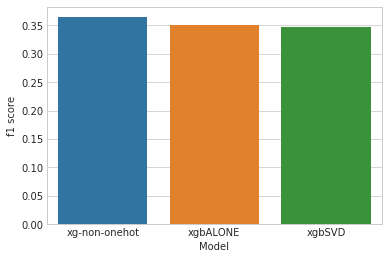

In [76]:
sns.set_style("whitegrid")
msplt = sns.barplot(x = "model", y = "f1_score", data=mscore_df)
_ = plt.xlabel('Model')
_ = plt.ylabel('f1 score')
_ = plt.savefig('model_selection_bar')
_ = plt.show()

In [71]:
#test on test set here.
#XGBoost non one-hot-encoded was the best model but only very slightly, XGB one-hot-encoded alone without
#feature reduction performed nearly as well and was much more efficient in time computations, thus I will use
#XGB w/o feature selection and with one-hot-encoding for my final modelling on test set as well as in other
#districts and whole city
#train the best estimator on the train set again then test on test set for results
best_XGB_only_estimator.fit(X_train, y_train)
preds = best_XGB_only_estimator.predict(X_test)
f1score = f1_score(y_test, preds, average = 'micro')

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [72]:
f1_score = []
f1_score.append(('Bayview', f1score))
export_df = pd.DataFrame(f1_score)
export_df.to_csv("bayviewresults.dat", index = False, header = False)